In [1]:
import pandas as pd

df = pd.read_csv('../dataset/data_분류된_형상설계.csv', encoding='utf-8')

In [ ]:
a = len(df), len(df[(df['fail_level'] == 15)]) 
print(a, a[1]/a[0]) #(11276, 3719) 0.32981553742461867

(11276, 3719) 0.32981553742461867


In [ ]:
import pandas as pd
import joblib
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

df = pd.read_csv("../dataset/shape_data.csv")
df["fail"] = (df["fail_level"] != 15).astype(int)

X = df.drop(columns=["fail_level", "fail"])
y = df["fail"]

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = LGBMClassifier(
    objective="binary",
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42,
)

clf.fit(
    X_tr,
    y_tr,
    eval_set=[(X_te, y_te)],
    eval_metric="auc",
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),     # ← 변경점
        lgb.log_evaluation(period=50)                # 로그 간격(원하면 0으로 끄기)
    ],
)

print("Best iteration:", clf.best_iteration_)
proba = clf.predict_proba(X_te, num_iteration=clf.best_iteration_)[:, 1]
print("AUC:", round(roc_auc_score(y_te, proba), 4))
print(classification_report(y_te, clf.predict(X_te), digits=3))

joblib.dump({"model": clf, "features": X.columns.tolist()},
            "fail_bin_lgbm.joblib")
print("Saved → fail_bin_lgbm.joblib")

[LightGBM] [Info] Number of positive: 6045, number of negative: 2975
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 9020, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 200 rounds
[50]	valid_0's auc: 0.920596	valid_0's binary_logloss: 0.384821
[100]	valid_0's auc: 0.92797	valid_0's binary_logloss: 0.318004
[150]	valid_0's auc: 0.931848	valid_0's binary_logloss: 0.295686
[200]	valid_0's auc: 0.934422	valid_0's binary_logloss: 0.285463
[250]	valid_0's auc: 0.935739	valid_0's binary_logloss: 0.279757
[300]	valid_0's auc: 0.936375	valid_0's binary_logloss: 0.276721
[350]	valid_0's auc: 0.937528	valid_0's binary_logloss: 0.274

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 9020, number of used features: 26
[LightGBM] [Info] Start training from score 10.454102
R²  : 0.7039
MAE : 1.138
|pred-true| ≤ 1  비율 : 62.9 %


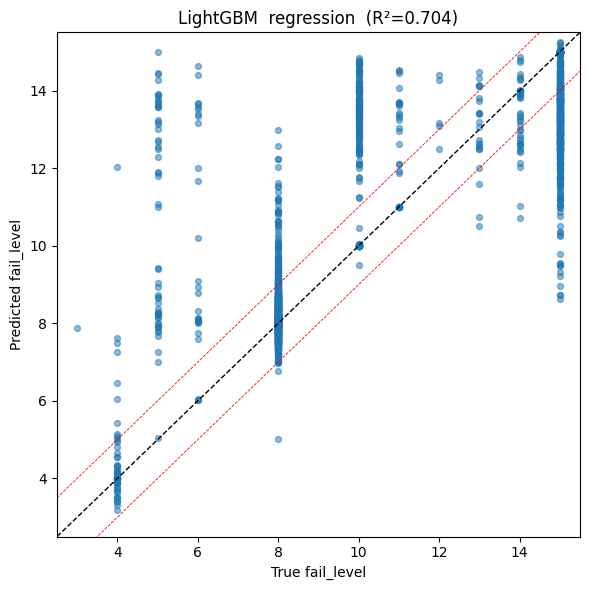

In [17]:
#!/usr/bin/env python3
"""
lgbm_reg_vis.py  –  fail_level 회귀 성능 시각화
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from lightgbm import LGBMRegressor

# 1) 데이터 로드 ----------------------------------------------------------
df = pd.read_csv("../dataset/shape_data.csv")     # 경로만 맞춰 주세요
y = df["fail_level"].astype(float)
X = df.drop(columns=["fail_level"])

# 2) 학습 / 검증 분할 -----------------------------------------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) 모델 학습 ------------------------------------------------------------
model = LGBMRegressor(
    objective="regression",
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_tr, y_tr,
          eval_set=[(X_te, y_te)],
          eval_metric="l2",
          callbacks=[])

# 4) 예측 & 지표 ----------------------------------------------------------
y_pred = model.predict(X_te, num_iteration=model.best_iteration_)
r2 = r2_score(y_te, y_pred)
mae = mean_absolute_error(y_te, y_pred)
within1 = np.mean(np.abs(y_pred - y_te) <= 1) * 100   # ±1 이내 비율

print(f"R²  : {r2:.4f}")
print(f"MAE : {mae:.3f}")
print(f"|pred-true| ≤ 1  비율 : {within1:.1f} %")

# 5) 시각화 ---------------------------------------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_te, y_pred, alpha=0.5, s=18)
lims = [y.min() - 0.5, y.max() + 0.5]
plt.plot(lims, lims, 'k--', lw=1)           # y=x
plt.plot(lims, [l + 1 for l in lims], 'r--', lw=0.6)   # +1 밴드
plt.plot(lims, [l - 1 for l in lims], 'r--', lw=0.6)   # -1 밴드
plt.xlabel("True fail_level")
plt.ylabel("Predicted fail_level")
plt.title(f"LightGBM  regression  (R²={r2:.3f})")
plt.xlim(lims)
plt.ylim(lims)
plt.tight_layout()
plt.show()

fail_level
8     5567
15    3719
10     766
5      321
4      291
14     236
11     136
6      125
13      83
12      29
3        2
7        1
Name: count, dtype: int64
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 9020, number of used features: 26
[LightGBM] [Info] Start training from score -9.107200
[LightGBM] [Info] Start training from score -3.656161
[LightGBM] [Info] Start training from score -3.558124
[LightGBM] [Info] Start training from score -4.502029
[LightGBM] [Info] Start training from score -0.705642
[LightGBM] [Info] Start training from score -2.688835
[LightGBM] [Info] Start training from score -4.415852
[LightGBM] [Info] Start training from score -5.971705
[LightGBM] [Info] Start training from score -4.

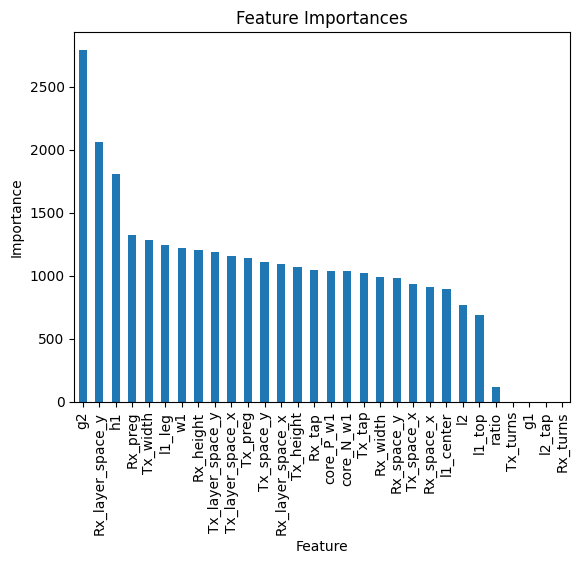

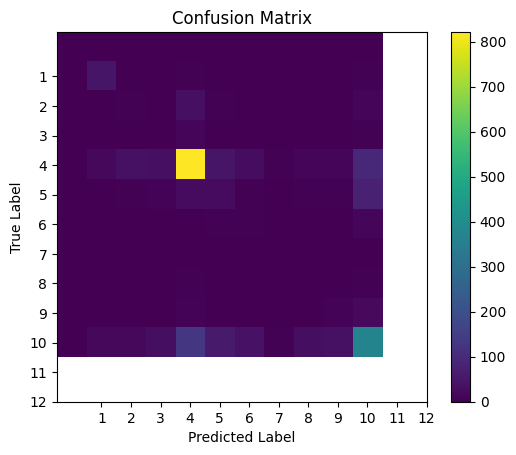

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('../dataset/shape_data.csv')
X = data.drop('fail_level', axis=1)
y = data['fail_level']

# 1) Inspect class counts
print(y.value_counts())

# 2) Keep only classes with ≥2 samples
counts = y.value_counts()
valid = counts[counts >= 2].index
mask = y.isin(valid)
X_filtered = X[mask]
y_filtered = y[mask]

# 3) Now you can stratify safely
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered,
    test_size=0.2,
    random_state=42,
    stratify=y_filtered
)

# 4. Initialize and train LightGBM classifier for multiclass
num_classes = y.nunique()
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=num_classes,
    random_state=42
)
model.fit(X_train, y_train)

# 5. Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 6. Feature importance visualization
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure()
importances.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

# 7. Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(range(1, num_classes + 1))
plt.yticks(range(1, num_classes + 1))
plt.colorbar()
plt.show()

[LightGBM] [Info] Number of positive: 2975, number of negative: 6045
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 9020, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.329823 -> initscore=-0.708987
[LightGBM] [Info] Start training from score -0.708987
              precision    recall  f1-score   support

      not 15       0.95      0.86      0.90      1512
       is 15       0.76      0.90      0.82       744

    accuracy                           0.87      2256
   macro avg       0.85      0.88      0.86      2256
weighted avg       0.88      0.87      0.88      2256



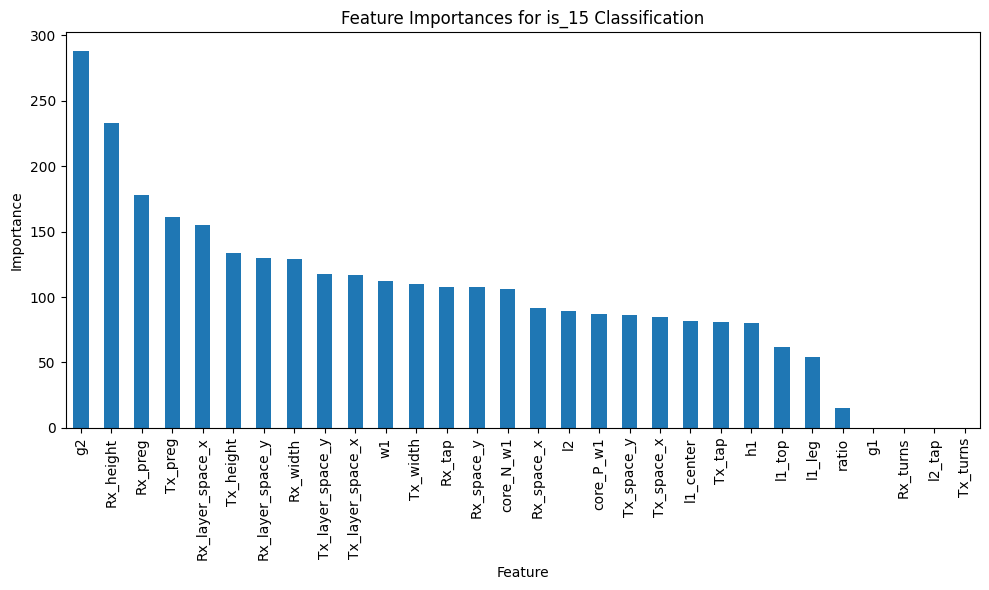

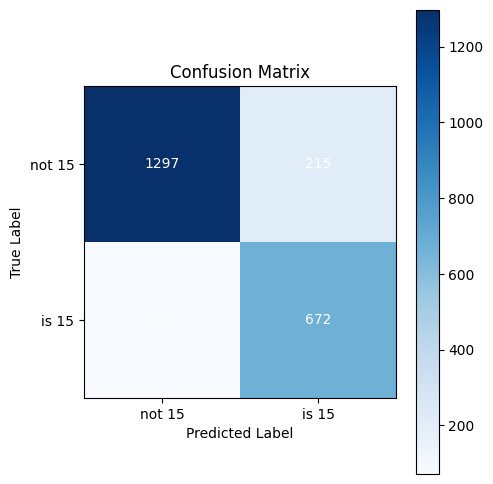

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt

# 1. Load the CSV file (adjust path as needed)
data = pd.read_csv('../dataset/shape_data.csv')

# 2. Create binary target: 1 if fail_level == 15, else 0
data['is_15'] = (data['fail_level'] == 15).astype(int)

# 3. Prepare features (drop the original fail_level and the new target from X) and target y
X = data.drop(['fail_level', 'is_15'], axis=1)
y = data['is_15']

# 4. Split into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 5. Initialize and train a LightGBM binary classifier
model = lgb.LGBMClassifier(
    objective='binary',
    random_state=42
)
model.fit(X_train, y_train)

# 6. Predict on the test set and print classification metrics
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['not 15', 'is 15']))

# 7. Plot feature importances
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title('Feature Importances for is_15 Classification')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# 8. Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['not 15', 'is 15'])
plt.yticks([0, 1], ['not 15', 'is 15'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.colorbar()
plt.tight_layout()
plt.show()

[LightGBM] [Info] Number of positive: 2975, number of negative: 6045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1611
[LightGBM] [Info] Number of data points in the train set: 9020, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.329823 -> initscore=-0.708987
[LightGBM] [Info] Start training from score -0.708987
              precision    recall  f1-score   support

      not 15       0.95      0.86      0.90      1512
       is 15       0.76      0.91      0.83       744

    accuracy                           0.87      2256
   macro avg       0.85      0.88      0.86      2256
weighted avg       0.89      0.87      0.88      2256



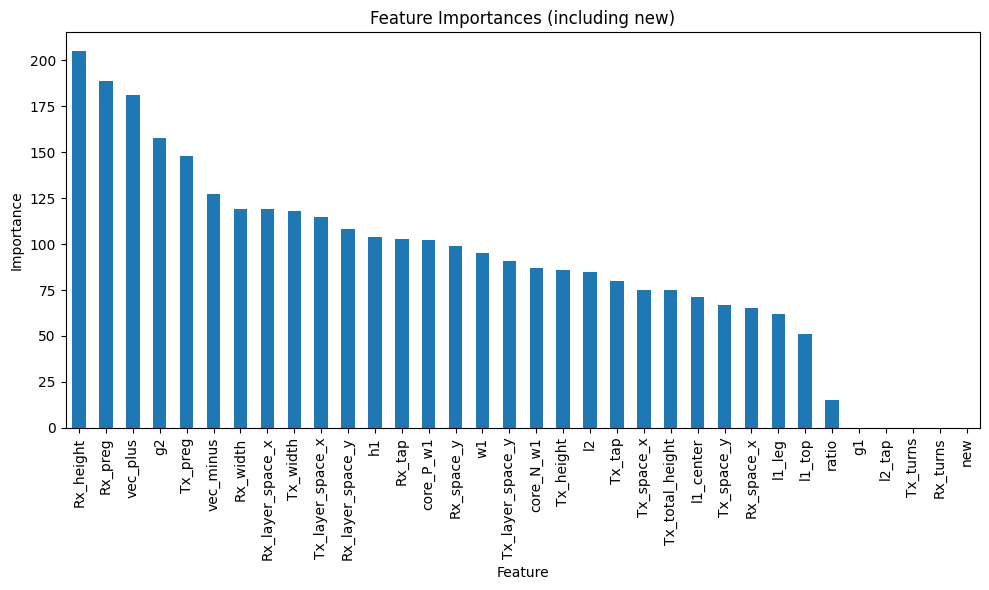

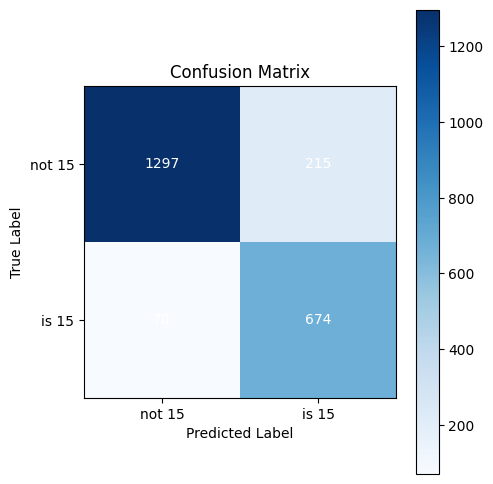

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt

# 1. Load dataset
data = pd.read_csv('../dataset/shape_data.csv')

# 2. Create binary target and new feature
data['is_15'] = (data['fail_level'] == 15).astype(int)
data['Tx_total_height'] = data['Tx_height'] + data['Tx_preg'] / 1.98

# 2) move-vector와 정확히 대응되는 두 피처
# “g2+(Tx_height+Tx_preg/1.98)”
data['vec_plus'] = data['g2'] + data['Tx_total_height']
# “g2-(Tx_height+Tx_preg/1.98)”
data['vec_minus'] = data['g2'] - data['Tx_total_height']

# 3) 기존의 new(0/1) 피처도 유지
data['new'] = (data['g2'] > data['Tx_total_height']).astype(int)


# 3. Prepare features (including 'new') and target
X = data.drop(['fail_level', 'is_15'], axis=1)
y = data['is_15']

# 4. Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 5. Train LightGBM binary classifier
model = lgb.LGBMClassifier(objective='binary', random_state=42)
model.fit(X_train, y_train)

# 6. Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['not 15', 'is 15']))

# 7. Feature importances (including 'new')
importances = pd.Series(model.feature_importances_,
                        index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title('Feature Importances (including new)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# 8. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['not 15', 'is 15'])
plt.yticks([0, 1], ['not 15', 'is 15'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.colorbar()
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd

# 1. Load data
df = pd.read_csv('../dataset/shape_data.csv')

# 2. Define success flag
df['is_15'] = (df['fail_level'] >=8).astype(int)

# 3. Define condition
condition = (
    df['Tx_height'] + df['Tx_preg'] / 2
    < df['g2'] + df['Tx_height'] / 0.7
    - df['Rx_preg'] / 2
    - df['Rx_height']
)

# 4. Filter and compute stats
subset = df[condition]
total = len(subset)
success = subset['is_15'].sum()
success_rate = success / total if total > 0 else 0

# 5. Prepare summary table
summary = pd.DataFrame({
    'count': [total],
    'success_count': [success],
    'success_rate': [round(success_rate, 4)]
}, index=['Condition True'])

# 6. Display results
print(f"Total samples meeting condition: {total}")
print(f"Success count (fail_level==15): {success}")
print(f"Success rate: {success_rate:.4f}\n")



Total samples meeting condition: 8610
Success count (fail_level==15): 8051
Success rate: 0.9351



[LightGBM] [Info] Number of positive: 2975, number of negative: 3913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1033
[LightGBM] [Info] Number of data points in the train set: 6888, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431911 -> initscore=-0.274060
[LightGBM] [Info] Start training from score -0.274060
              precision    recall  f1-score   support

      fail<8       0.95      0.76      0.85       978
     fail>=8       0.75      0.95      0.84       744

    accuracy                           0.84      1722
   macro avg       0.85      0.86      0.84      1722
weighted avg       0.87      0.84      0.84      1722



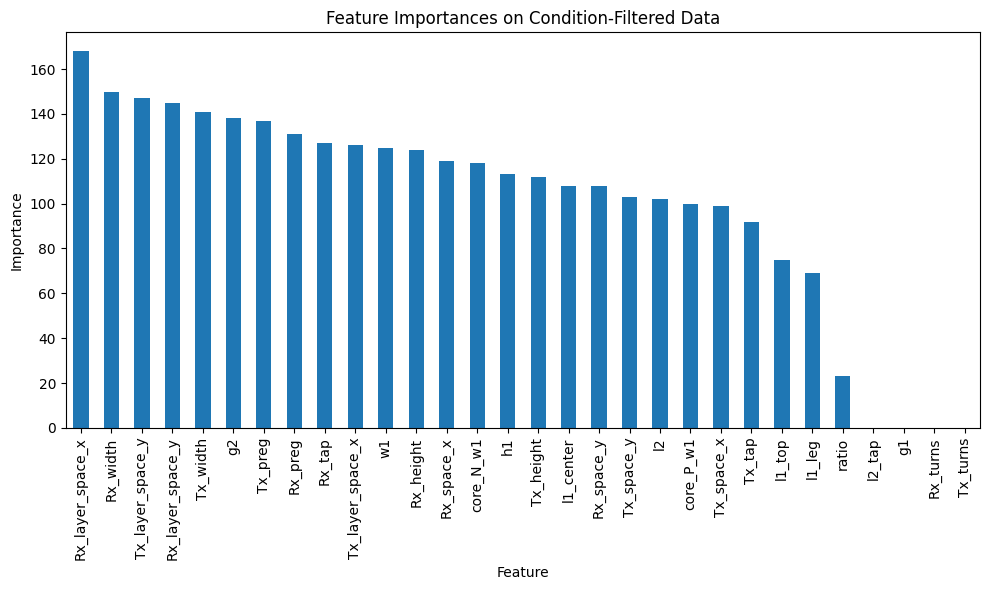

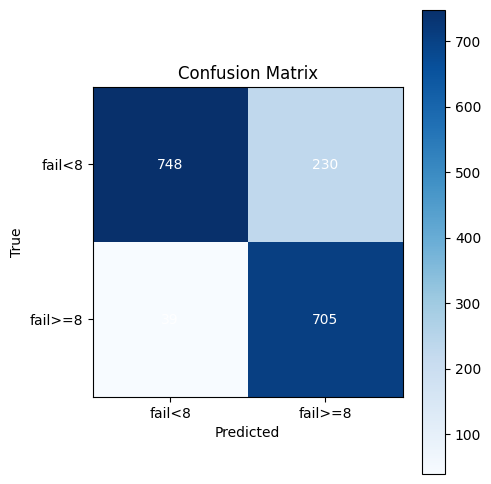

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt

# 1. 데이터 로드
df = pd.read_csv('../dataset/shape_data.csv')

# 2. 성공 플래그 정의: fail_level >= 8
df['is_15'] = (df['fail_level'] >= 15).astype(int)

# 3. 조건 정의 (이전에 찾은 조합)
condition = (
    df['Tx_height'] + df['Tx_preg'] / 2
    < df['g2'] + df['Tx_height'] / 0.7
    - df['Rx_preg'] / 2
    - df['Rx_height']
)

# 4. 조건을 만족하는 데이터만 필터
subset = df[condition].copy()
X = subset.drop(['fail_level', 'is_15'], axis=1)
y = subset['is_15']

# 5. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 6. LightGBM 모델 학습
model = lgb.LGBMClassifier(objective='binary', random_state=42)
model.fit(X_train, y_train)

# 7. 예측 및 평가
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=['fail<8', 'fail>=8']))

# 8. 피처 중요도 시각화
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title('Feature Importances on Condition-Filtered Data')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# 9. 혼동 행렬
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], ['fail<8', 'fail>=8'])
plt.yticks([0, 1], ['fail<8', 'fail>=8'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.colorbar()
plt.tight_layout()
plt.show()